In [8]:
pip install jax jaxlib

  Using cached jax-0.4.38-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.38-cp311-cp311-macosx_11_0_arm64.whl.metadata (1.0 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (21 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
Using cached jax-0.4.38-py3-none-any.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 MB 8.7 MB/s eta 0:00:0000:0100:01
Using cached ml_dtypes-0.5.1-cp311-cp311-macosx_10_9_universal2.whl (671 kB)
Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Test: context 2048, prediction 96
### Github: https://github.com/google-research/timesfm?tab=readme-ov-file#install-from-pypi-and-publish
### HF: https://huggingface.co/google/timesfm-1.0-200m 
### - 2048 is the maxmimum context window, and context windows need to be multiples of 32. Prediction window size is unlimited
### - documentation recommends context window >= prediction window

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 55431.33it/s]



Full Period Metrics:
MAE: 168.9421
MSE: 41397.8635
RMSE: 203.4646
MAPE: 2.9499
SMAPE: 2.9350
MASE: 6.5189


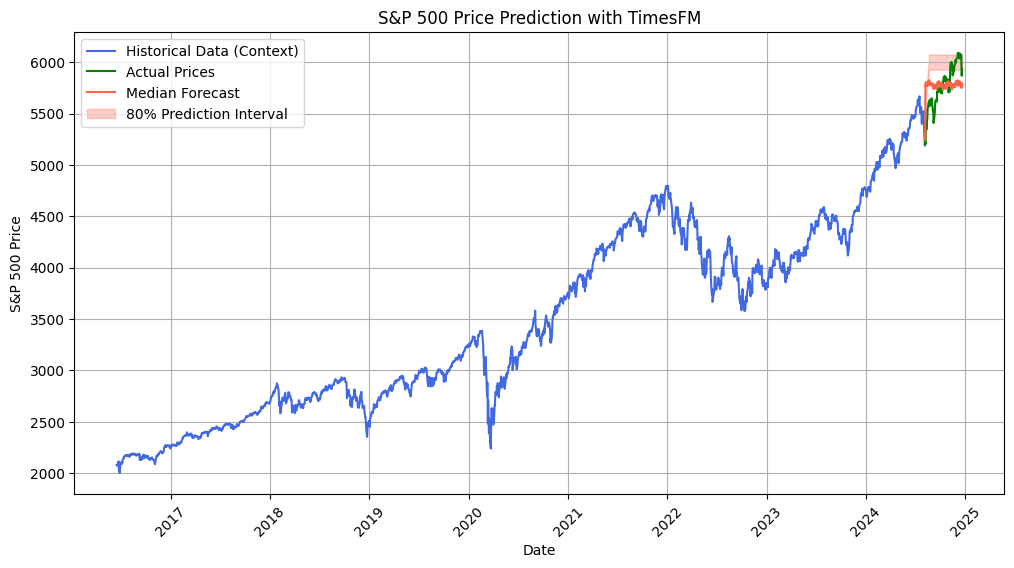


COVID Period Metrics:
MAE: 393.0585
MSE: 205341.7751
RMSE: 453.1465
MAPE: 8.5783
SMAPE: 9.0822
MASE: 11.1716


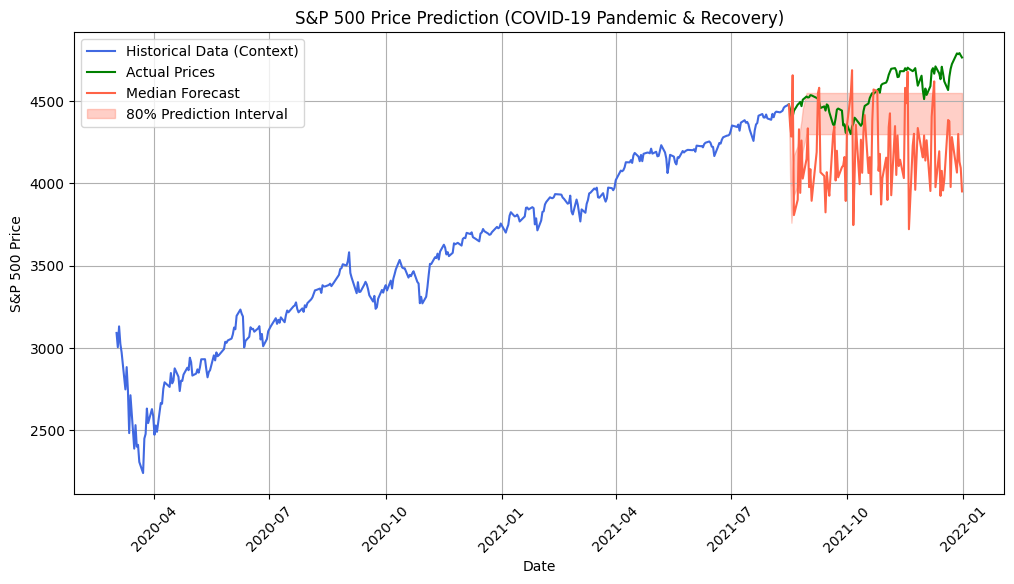

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timesfm

from data.snp500 import snp500_daily
from utils.metrics import metric

CONTEXT_WINDOW = 2048  # Must be multiple of 32 for TimesFM
PREDICTION_WINDOW = 96

# Initialize TimesFM model with the 2.0-500m checkpoint
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="mps",
        per_core_batch_size=32,
        horizon_len=PREDICTION_WINDOW,
        num_layers=50,  # Required for 500m model
        context_len=2048,  # Max context length for TimesFM 2.0
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
)

# Prepare the data - using raw Close prices
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]

def generate_forecast(context_data):
    """Generate and process forecast using TimesFM"""
    # Ensure data is 1D
    context = np.asarray(context_data).flatten()
    
    # We use frequency=0 for daily data as per documentation
    point_forecast, quantile_forecast = tfm.forecast(
        [context],
        freq=[0],  # 0 for high-frequency (daily) data
    )
    
    # Extract median forecast and pad/truncate to match prediction window
    median = point_forecast[0]  # First element since we only have one series
    if len(median) < PREDICTION_WINDOW:
        # Pad if shorter
        median = np.pad(median, (0, PREDICTION_WINDOW - len(median)), 'edge')
    else:
        # Truncate if longer
        median = median[:PREDICTION_WINDOW]
    
    # Get quantiles from experimental quantile forecasts
    quantiles = quantile_forecast[0]  # First element for our single series
    
    # Process low and high quantiles
    low = quantiles[1]  # 10th percentile
    high = quantiles[8]  # 90th percentile
    
    # Pad/truncate quantiles to match prediction window
    if len(low) < PREDICTION_WINDOW:
        low = np.pad(low, (0, PREDICTION_WINDOW - len(low)), 'edge')
        high = np.pad(high, (0, PREDICTION_WINDOW - len(high)), 'edge')
    else:
        low = low[:PREDICTION_WINDOW]
        high = high[:PREDICTION_WINDOW]
    
    return low, median, high

def calculate_metrics(actual, predicted, insample=None):
    """Calculate all metrics using the metrics.py implementations"""
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Calculate basic metrics
    mae, mse, rmse, mape, mspe = metric(predicted, actual)

    # Calculate SMAPE
    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )

    # Calculate MASE
    if insample is not None:
        naive_forecast = insample[:-1]
        naive_target = insample[1:]
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan

    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape * 100,
        "SMAPE": smape,
        "MASE": mase if not np.isnan(mase) else None,
    }

    return metrics

def plot_forecast(
    data,
    context_window,
    prediction_window,
    median_forecast,
    low_forecast,
    high_forecast,
    title,
):
    """Create visualization with zoomed context"""
    plt.figure(figsize=(12, 6))

    # Get the last point of historical context
    last_context_point = data["Close"].iloc[-prediction_window - 1]

    # Add last context point to forecasts for continuity
    median_forecast = np.insert(median_forecast, 0, last_context_point)
    low_forecast = np.insert(low_forecast, 0, last_context_point)
    high_forecast = np.insert(high_forecast, 0, last_context_point)

    # Create forecast dates
    forecast_dates = pd.concat(
        [
            data["Date"].iloc[-(prediction_window + 1) : -prediction_window],
            data["Date"].iloc[-prediction_window:],
        ]
    )

    # Get actual prices including last context point
    actual_prices = data["Close"].iloc[-prediction_window:].values
    actual_prices = np.insert(actual_prices, 0, last_context_point)

    # Plot historical context
    plt.plot(
        data["Date"].iloc[-(context_window + prediction_window) : -prediction_window],
        data["Close"].iloc[-(context_window + prediction_window) : -prediction_window],
        color="royalblue",
        label="Historical Data (Context)",
    )

    # Plot actual prices
    plt.plot(forecast_dates, actual_prices, color="green", label="Actual Prices")

    # Plot forecast
    plt.plot(forecast_dates, median_forecast, color="tomato", label="Median Forecast")
    plt.fill_between(
        forecast_dates,
        low_forecast,
        high_forecast,
        color="tomato",
        alpha=0.3,
        label="80% Prediction Interval",
    )

    plt.xlabel("Date")
    plt.ylabel("S&P 500 Price")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

# Generate full period forecast
context = sp500_d["Close"].values[-CONTEXT_WINDOW:]
low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d["Close"].values[-PREDICTION_WINDOW:]
insample_data = sp500_d["Close"].values[
    -CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW
]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    "S&P 500 Price Prediction with TimesFM",
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d["Date"] >= covid_start_date) & (sp500_d["Date"] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = (
    covid_data["Close"]
    .iloc[-(CONTEXT_WINDOW + PREDICTION_WINDOW) : -PREDICTION_WINDOW]
    .values
)

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data["Close"].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = (
    covid_data["Close"]
    .iloc[-CONTEXT_WINDOW - PREDICTION_WINDOW : -PREDICTION_WINDOW]
    .values
)
metrics_covid = calculate_metrics(
    actual_prices_covid, median_covid, insample=insample_data_covid
)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    if value is not None:
        print(f"{metric_name}: {value:.4f}")
    else:
        print(f"{metric_name}: N/A")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    "S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)",
)

# Experimenting with different context and prediction windows for different frequencies: daily, weekly, monthly. Made the context windows larger to test up till its max 2048 window(for daily frequency).

In [ ]:
from dataclasses import dataclass

@dataclass
class TimesFMExperimentConfig:
    """Experiment configuration for TimesFM"""
    
    daily_config = {
        "context_windows": [96, 192, 512, 1024, 2048],
        "short_term_windows": [48, 64],
        "long_term_windows": [96, 192, 336],
    }
    
    weekly_config = {
        "context_windows": [32, 64, 96, 128],
        "short_term_windows": [12, 24],
        "long_term_windows": [48, 64, 96],
    }
    
    monthly_config = {
        "context_windows": [32, 64, 96],
        "short_term_windows": [3, 6],
        "long_term_windows": [12, 24],
    }


Running daily frequency experiments...


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 74898.29it/s]


Prediction window: 48
Median forecast length: 48
Number of quantiles: 48
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 55676.60it/s]


Prediction window: 64
Median forecast length: 64
Number of quantiles: 64
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 81180.08it/s]


Prediction window: 96
Median forecast length: 96
Number of quantiles: 96
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 75346.78it/s]


Prediction window: 192
Median forecast length: 192
Number of quantiles: 192
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 79137.81it/s]


Prediction window: 336
Median forecast length: 336
Number of quantiles: 336
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 64198.53it/s]


Prediction window: 48
Median forecast length: 48
Number of quantiles: 48
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 80659.69it/s]


Prediction window: 64
Median forecast length: 64
Number of quantiles: 64
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 87992.39it/s]


Prediction window: 96
Median forecast length: 96
Number of quantiles: 96
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 100663.30it/s]


Prediction window: 192
Median forecast length: 192
Number of quantiles: 192
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 76725.07it/s]


Prediction window: 336
Median forecast length: 336
Number of quantiles: 336
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 85598.04it/s]


Prediction window: 48
Median forecast length: 48
Number of quantiles: 48
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 74455.10it/s]


Prediction window: 64
Median forecast length: 64
Number of quantiles: 64
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 66930.38it/s]


Prediction window: 96
Median forecast length: 96
Number of quantiles: 96
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 74898.29it/s]


Prediction window: 192
Median forecast length: 192
Number of quantiles: 192
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 36684.87it/s]


Prediction window: 336
Median forecast length: 336
Number of quantiles: 336
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 85598.04it/s]


Prediction window: 48
Median forecast length: 48
Number of quantiles: 48
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 63550.06it/s]


Prediction window: 64
Median forecast length: 64
Number of quantiles: 64
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 81180.08it/s]


Prediction window: 96
Median forecast length: 96
Number of quantiles: 96
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 54471.48it/s]


Prediction window: 192
Median forecast length: 192
Number of quantiles: 192
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 93902.33it/s]


Prediction window: 336
Median forecast length: 336
Number of quantiles: 336
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 93206.76it/s]


Prediction window: 48
Median forecast length: 48
Number of quantiles: 48
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 74455.10it/s]


Prediction window: 64
Median forecast length: 64
Number of quantiles: 64
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 73156.47it/s]


Prediction window: 96
Median forecast length: 96
Number of quantiles: 96
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 91180.52it/s]


Prediction window: 192
Median forecast length: 192
Number of quantiles: 192
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 99864.38it/s]


Prediction window: 336
Median forecast length: 336
Number of quantiles: 336
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

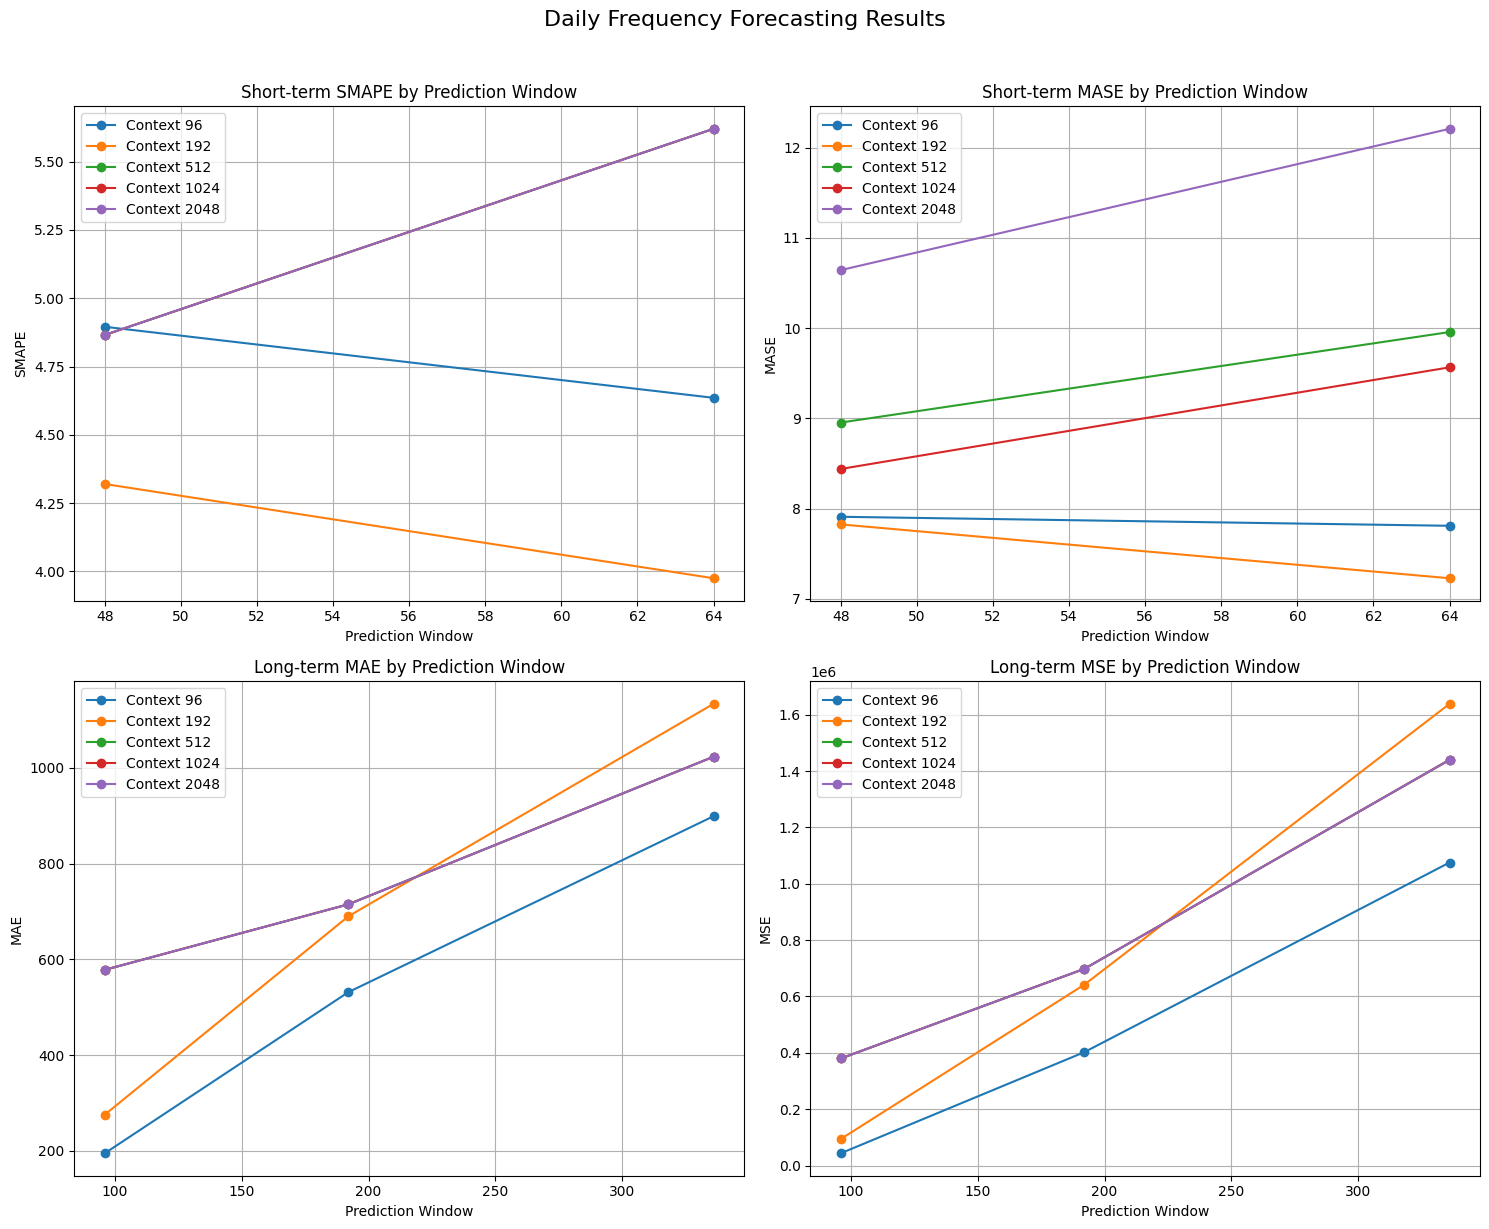


Daily Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE    MAPE     MASE          MSE  \
Context Window Prediction Window                                           
96             48                 284.3523  4.7595   7.9094   95133.4327   
               64                 267.7956  4.5185   7.8096   81029.8443   
192            48                 251.5199  4.2144   7.8249   73906.7761   
               64                 230.5930  3.8783   7.2283   67534.3626   
512            48                 282.2170  4.7292   8.9537   95048.6855   
               64                 321.5875  5.4293   9.9566  130334.0950   
1024           48                 282.2170  4.7292   8.4395   95048.6855   
               64                 321.5875  5.4293   9.5657  130334.0950   
2048           48                 282.2170  4.7292  10.6431   95048.6855   
               64                 321.5875  5.4293  12.2088  130334.0950   

Metric                      

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 79137.81it/s]


Prediction window: 12
Median forecast length: 12
Number of quantiles: 12
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 88612.06it/s]


Prediction window: 24
Median forecast length: 24
Number of quantiles: 24
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 90524.55it/s]


Prediction window: 48
Median forecast length: 48
Number of quantiles: 48
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 71493.82it/s]


Prediction window: 64
Median forecast length: 64
Number of quantiles: 64
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 74898.29it/s]


Prediction window: 96
Median forecast length: 96
Number of quantiles: 96
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 85598.04it/s]


Prediction window: 12
Median forecast length: 12
Number of quantiles: 12
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 75346.78it/s]


Prediction window: 24
Median forecast length: 24
Number of quantiles: 24
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 90524.55it/s]


Prediction window: 48
Median forecast length: 48
Number of quantiles: 48
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 61082.10it/s]


Prediction window: 64
Median forecast length: 64
Number of quantiles: 64
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 68385.39it/s]


Prediction window: 96
Median forecast length: 96
Number of quantiles: 96
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 83886.08it/s]


Prediction window: 12
Median forecast length: 12
Number of quantiles: 12
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 96791.63it/s]


Prediction window: 24
Median forecast length: 24
Number of quantiles: 24
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 83330.54it/s]


Prediction window: 48
Median forecast length: 48
Number of quantiles: 48
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 71493.82it/s]


Prediction window: 64
Median forecast length: 64
Number of quantiles: 64
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 66576.25it/s]


Prediction window: 96
Median forecast length: 96
Number of quantiles: 96
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 73156.47it/s]


Prediction window: 12
Median forecast length: 12
Number of quantiles: 12
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 58525.17it/s]


Prediction window: 24
Median forecast length: 24
Number of quantiles: 24
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 74455.10it/s]


Prediction window: 48
Median forecast length: 48
Number of quantiles: 48
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 88612.06it/s]


Prediction window: 64
Median forecast length: 64
Number of quantiles: 64
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 85598.04it/s]


Prediction window: 96
Median forecast length: 96
Number of quantiles: 96
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


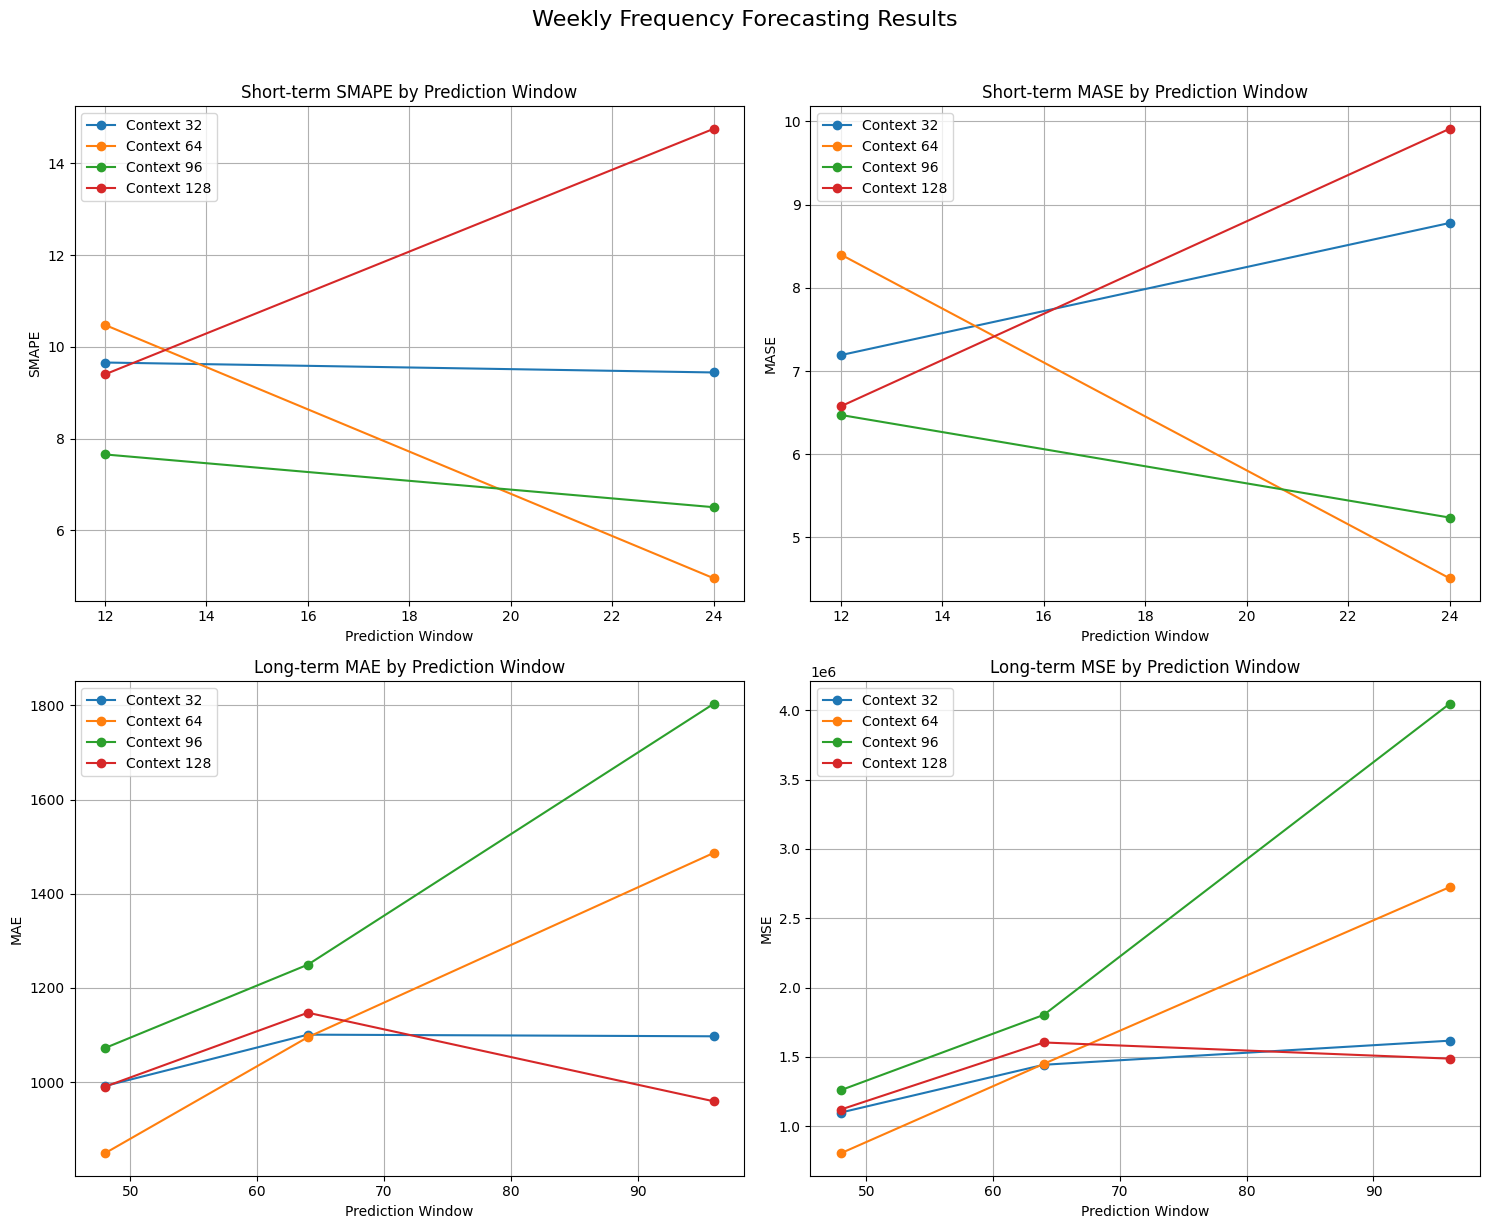


Weekly Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE     MAPE    MASE          MSE  \
Context Window Prediction Window                                           
32             12                 544.8144   9.1917  7.1911  313591.5527   
               24                 520.1251   8.9739  8.7785  303363.8487   
64             12                 589.3306   9.9304  8.3989  367973.1270   
               24                 280.2887   4.8094  4.5100   98197.0285   
96             12                 436.3808   7.3417  6.4718  213797.8384   
               24                 364.5143   6.2627  5.2392  160652.3393   
128            12                 531.4126   8.9612  6.5759  296062.2082   
               24                 789.8351  13.5888  9.9101  734407.8504   

Metric                                RMSE    SMAPE  
Context Window Prediction Window                     
32             12                 559.9925   9.6589  
               24

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 71493.82it/s]


Prediction window: 3
Median forecast length: 3
Number of quantiles: 3
Quantile lengths: [10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 54471.48it/s]


Prediction window: 6
Median forecast length: 6
Number of quantiles: 6
Quantile lengths: [10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 79137.81it/s]


Prediction window: 12
Median forecast length: 12
Number of quantiles: 12
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 90524.55it/s]


Prediction window: 24
Median forecast length: 24
Number of quantiles: 24
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 87992.39it/s]


Prediction window: 3
Median forecast length: 3
Number of quantiles: 3
Quantile lengths: [10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 78643.20it/s]


Prediction window: 6
Median forecast length: 6
Number of quantiles: 6
Quantile lengths: [10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 90524.55it/s]


Prediction window: 12
Median forecast length: 12
Number of quantiles: 12
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 81180.08it/s]


Prediction window: 24
Median forecast length: 24
Number of quantiles: 24
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 45425.68it/s]


Prediction window: 3
Median forecast length: 3
Number of quantiles: 3
Quantile lengths: [10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 102300.10it/s]


Prediction window: 6
Median forecast length: 6
Number of quantiles: 6
Quantile lengths: [10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 57719.78it/s]


Prediction window: 12
Median forecast length: 12
Number of quantiles: 12
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 93902.33it/s]


Prediction window: 24
Median forecast length: 24
Number of quantiles: 24
Quantile lengths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


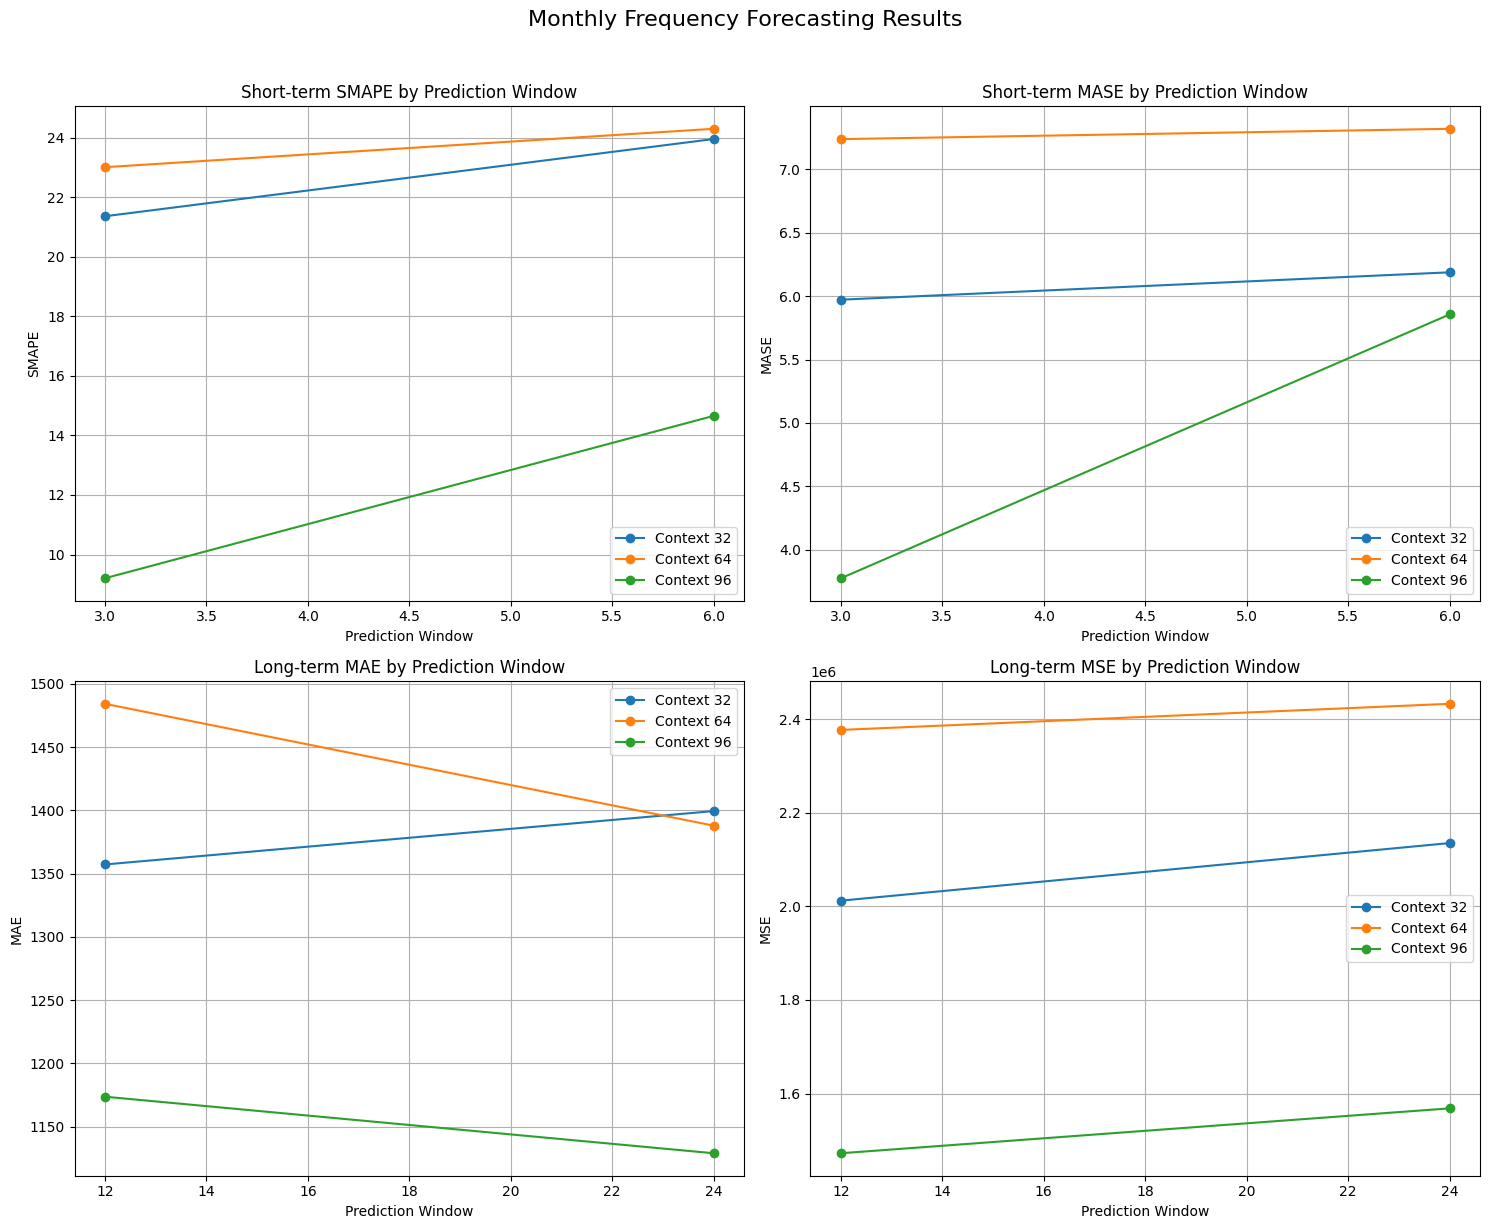


Monthly Frequency Results:

Short-term Forecasting Results:
Metric                                  MAE     MAPE    MASE           MSE  \
Context Window Prediction Window                                             
32             3                  1134.7118  19.2788  5.9720  1.305884e+06   
               6                  1233.5207  21.3667  6.1880  1.544279e+06   
64             3                  1213.1541  20.6062  7.2386  1.495985e+06   
               6                  1249.2047  21.6512  7.3200  1.575036e+06   
96             3                   518.1442   8.7780  3.7747  2.845461e+05   
               6                   788.1029  13.6379  5.8557  6.360804e+05   

Metric                                 RMSE    SMAPE  
Context Window Prediction Window                      
32             3                  1142.7529  21.3591  
               6                  1242.6901  23.9518  
64             3                  1223.1045  23.0062  
               6                  1255.

In [12]:
import numpy as np
import timesfm
from utils.evaluate import ContextPredictionWindowEvaluator
from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.visualization import plot_results_by_frequency


def initialize_timesfm(prediction_window):
    """Initialize TimesFM model with given prediction window"""
    return timesfm.TimesFm(
        hparams=timesfm.TimesFmHparams(
            backend="cpu",  # Change to "gpu" if available
            per_core_batch_size=32,
            horizon_len=prediction_window,
            num_layers=50,  # Required for 500m model
            context_len=2048,  # Max context length for TimesFM 2.0
        ),
        checkpoint=timesfm.TimesFmCheckpoint(
            huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
        ),
    )

def timesfm_forecast(model, context, prediction_window):
    """Generate forecast using TimesFM with dynamic prediction length"""
    # Initialize model if None
    if model is None:
        model = initialize_timesfm(prediction_window)
    
    # Ensure context is 1D
    context = np.asarray(context).flatten()
    
    # Determine frequency based on prediction window
    # 0: high frequency (daily)
    # 1: medium frequency (weekly)
    # 2: low frequency (monthly)
    if prediction_window <= 64:  # Short-term daily/weekly
        freq = 0
    elif prediction_window <= 96:  # Medium-term weekly/monthly
        freq = 1
    else:  # Long-term
        freq = 0  # Keep as daily for longer predictions
    
    # Generate forecast
    point_forecast, quantile_forecast = model.forecast(
        [context],
        freq=[freq],
    )
    
    # Extract and process forecasts
    median = point_forecast[0]  # First element since we only have one series
    quantiles = quantile_forecast[0]  # First element for our single series
    
    # Debug information
    print(f"Prediction window: {prediction_window}")
    print(f"Median forecast length: {len(median)}")
    print(f"Number of quantiles: {len(quantiles)}")
    print(f"Quantile lengths: {[len(q) for q in quantiles]}")
    
    # Get prediction intervals based on available quantiles
    num_quantiles = len(quantiles)
    # If we have enough quantiles, use 10th and 90th percentiles
    # Otherwise, use first and last available quantiles
    if num_quantiles >= 9:
        low = quantiles[1]  # 10th percentile
        high = quantiles[8]  # 90th percentile
    else:
        # For fewer quantiles, use the first and last
        low = quantiles[0]
        high = quantiles[-1]
        print(f"Warning: Only {num_quantiles} quantiles available. Using first and last quantiles.")
    
    # Ensure predictions match the required length
    if len(median) < prediction_window:
        # Pad if shorter
        median = np.pad(median, (0, prediction_window - len(median)), 'edge')
        low = np.pad(low, (0, prediction_window - len(low)), 'edge')
        high = np.pad(high, (0, prediction_window - len(high)), 'edge')
    else:
        # Truncate if longer
        median = median[:prediction_window]
        low = low[:prediction_window]
        high = high[:prediction_window]
    
    # Validate prediction length
    assert len(median) == prediction_window, (
        f"Prediction length mismatch: got {len(median)}, expected {prediction_window}"
    )
    
    return low, median, high

# Initialize experiment runner with dummy model
dummy_model = None  # Model will be created dynamically in timesfm_forecast

experiments = ContextPredictionWindowEvaluator(
    model=dummy_model,
    forecast_fn=timesfm_forecast,
    config=TimesFMExperimentConfig()
)

# Dictionary to store results for each frequency
frequency_results = {}

# Run experiments for each frequency
frequencies = {
    "daily": snp500_daily,
    "weekly": snp500_weekly,
    "monthly": snp500_monthly,
}

for freq, data in frequencies.items():
    print(f"\nRunning {freq} frequency experiments...")
    
    # Run experiments
    results = experiments.run_frequency_experiments(data, freq)
    frequency_results[freq] = results
    
    # Format results
    df_results = experiments.format_results(results)
    
    # Create visualizations
    plot_results_by_frequency(df_results, freq)
    
    # Create separate DataFrames for short-term and long-term results
    short_term_df = (
        df_results[df_results["Horizon"] == "short_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )
    
    long_term_df = (
        df_results[df_results["Horizon"] == "long_term"]
        .pivot_table(
            index=["Context Window", "Prediction Window"],
            columns="Metric",
            values="Value",
        )
        .round(4)
    )
    
    print(f"\n{freq.capitalize()} Frequency Results:")
    print("\nShort-term Forecasting Results:")
    print(short_term_df)
    print("\nLong-term Forecasting Results:")
    print(long_term_df)

Generating plots for extended period...


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 69905.07it/s]



Forecast debug info:
Point forecast shape: (1, 64)
Quantile forecast shape: (1, 64, 10)
Number of quantiles available: 64

Debug info for daily short-term:
Context window: 192
Prediction window: 64
Median forecast length: 64
Low forecast length: 64
High forecast length: 64


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 71493.82it/s]



Forecast debug info:
Point forecast shape: (1, 96)
Quantile forecast shape: (1, 96, 10)
Number of quantiles available: 96

Debug info for daily long-term:
Context window: 96
Prediction window: 96
Median forecast length: 96
Low forecast length: 96
High forecast length: 96


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 85598.04it/s]



Forecast debug info:
Point forecast shape: (1, 24)
Quantile forecast shape: (1, 24, 10)
Number of quantiles available: 24

Debug info for weekly short-term:
Context window: 64
Prediction window: 24
Median forecast length: 24
Low forecast length: 24
High forecast length: 24


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 52648.17it/s]



Forecast debug info:
Point forecast shape: (1, 48)
Quantile forecast shape: (1, 48, 10)
Number of quantiles available: 48

Debug info for weekly long-term:
Context window: 64
Prediction window: 48
Median forecast length: 48
Low forecast length: 48
High forecast length: 48


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 81180.08it/s]



Forecast debug info:
Point forecast shape: (1, 3)
Quantile forecast shape: (1, 3, 10)
Number of quantiles available: 3
Using first and last of 3 quantiles for intervals

Debug info for monthly short-term:
Context window: 96
Prediction window: 3
Median forecast length: 3
Low forecast length: 3
High forecast length: 3


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 71089.90it/s]



Forecast debug info:
Point forecast shape: (1, 24)
Quantile forecast shape: (1, 24, 10)
Number of quantiles available: 24

Debug info for monthly long-term:
Context window: 96
Prediction window: 24
Median forecast length: 24
Low forecast length: 24
High forecast length: 24


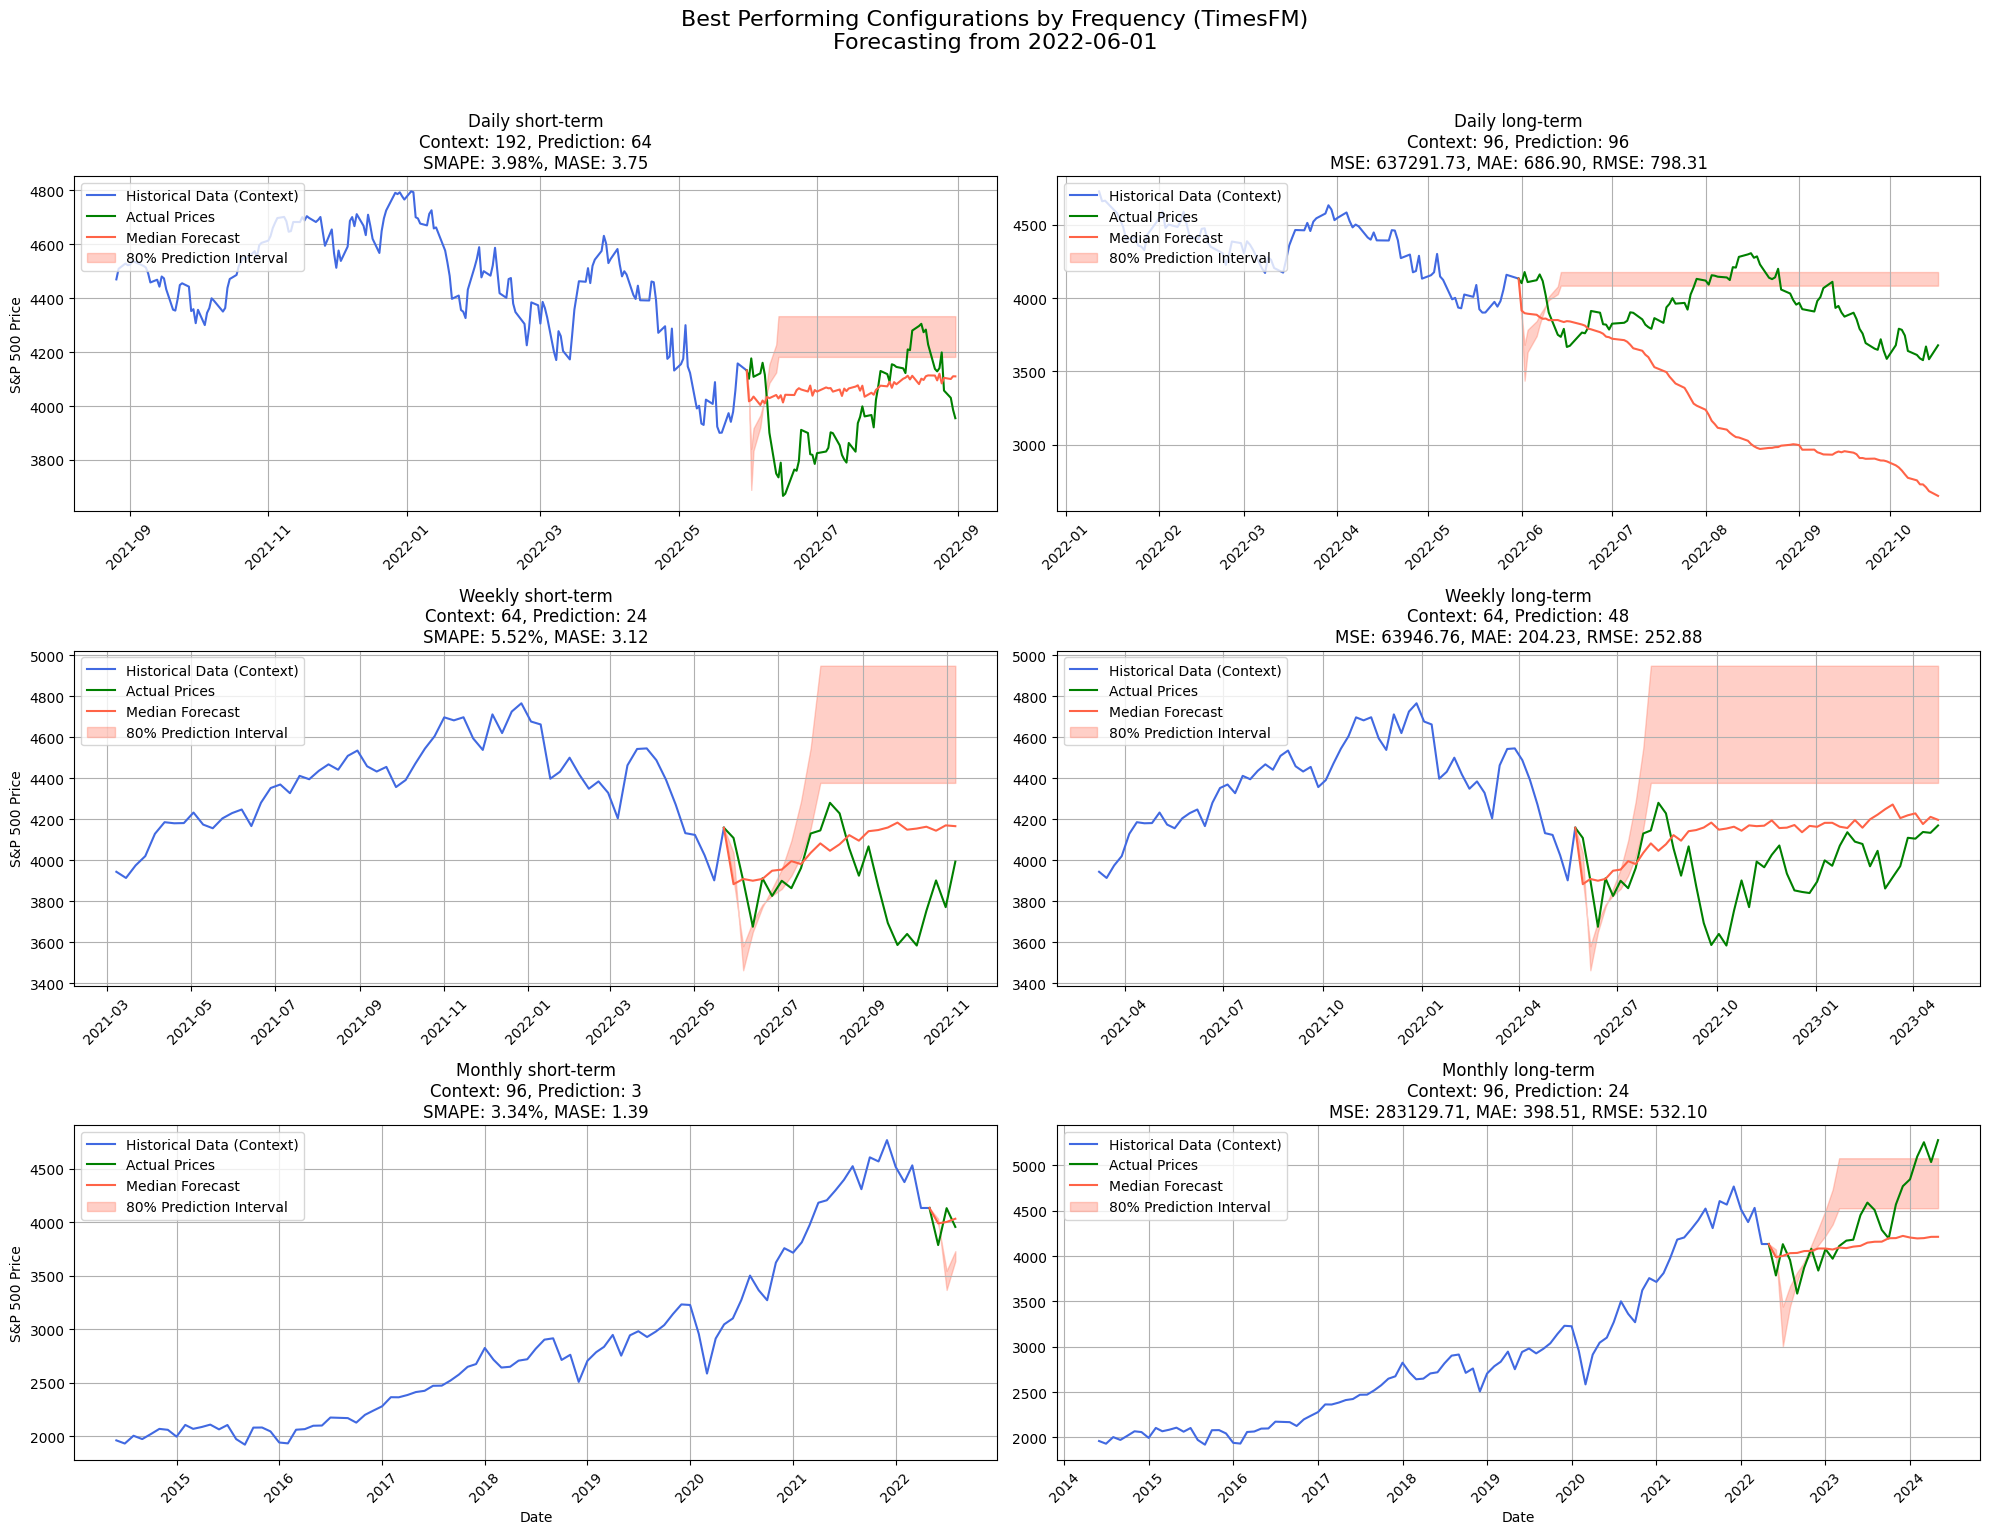


Generating plots for COVID period...


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 71493.82it/s]



Forecast debug info:
Point forecast shape: (1, 64)
Quantile forecast shape: (1, 64, 10)
Number of quantiles available: 64

Debug info for daily short-term:
Context window: 192
Prediction window: 64
Median forecast length: 64
Low forecast length: 64
High forecast length: 64


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 77195.78it/s]



Forecast debug info:
Point forecast shape: (1, 96)
Quantile forecast shape: (1, 96, 10)
Number of quantiles available: 96

Debug info for daily long-term:
Context window: 96
Prediction window: 96
Median forecast length: 96
Low forecast length: 96
High forecast length: 96


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 91180.52it/s]



Forecast debug info:
Point forecast shape: (1, 24)
Quantile forecast shape: (1, 24, 10)
Number of quantiles available: 24

Debug info for weekly short-term:
Context window: 64
Prediction window: 24
Median forecast length: 24
Low forecast length: 24
High forecast length: 24


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 79638.68it/s]



Forecast debug info:
Point forecast shape: (1, 48)
Quantile forecast shape: (1, 48, 10)
Number of quantiles available: 48

Debug info for weekly long-term:
Context window: 64
Prediction window: 48
Median forecast length: 48
Low forecast length: 48
High forecast length: 48


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 78643.20it/s]



Forecast debug info:
Point forecast shape: (1, 3)
Quantile forecast shape: (1, 3, 10)
Number of quantiles available: 3
Using first and last of 3 quantiles for intervals

Debug info for monthly short-term:
Context window: 96
Prediction window: 3
Median forecast length: 3
Low forecast length: 3
High forecast length: 3


Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 91180.52it/s]



Forecast debug info:
Point forecast shape: (1, 24)
Quantile forecast shape: (1, 24, 10)
Number of quantiles available: 24

Debug info for monthly long-term:
Context window: 96
Prediction window: 24
Median forecast length: 24
Low forecast length: 24
High forecast length: 24


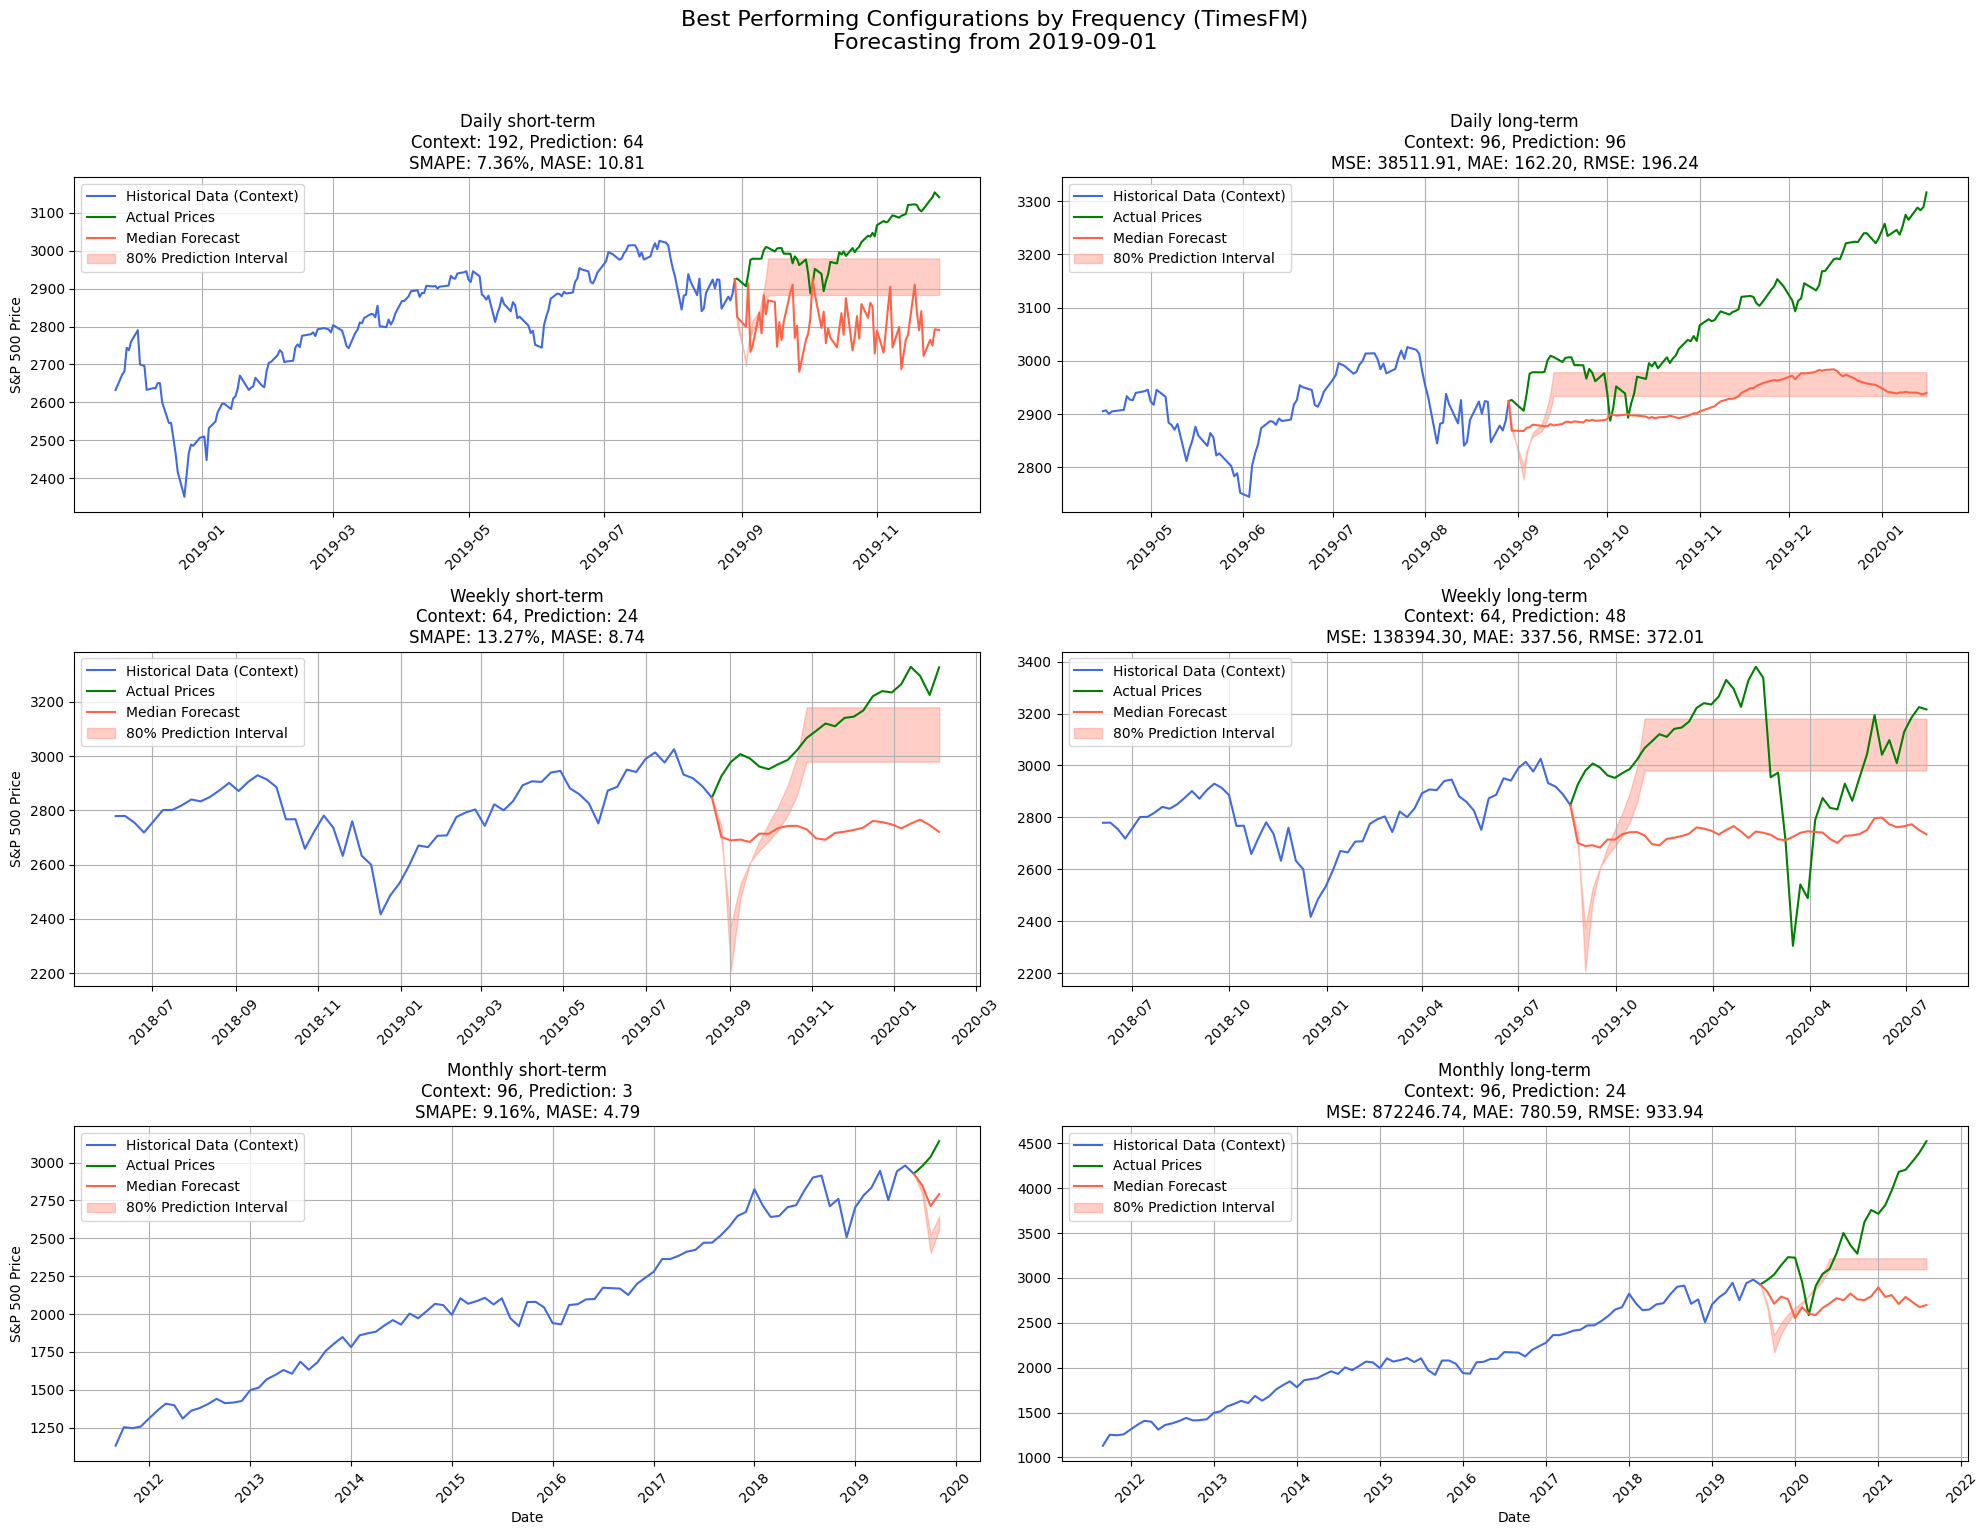


Metrics Comparison - Extended Period vs COVID Period:

Daily Frequency Results:

Short-term metrics:
Extended Period (forecast from 2023-06-01):
context: 192.0000
prediction: 64.0000
MSE: 53767.0865
MAE: 214.3839
RMSE: 231.8773
SMAPE: 7.3583
MASE: 10.8100

COVID Period (forecast from 2020-09-01):
context: 192.0000
prediction: 64.0000
MSE: 53767.0865
MAE: 214.3839
RMSE: 231.8773
SMAPE: 7.3583
MASE: 10.8100

Long-term metrics:
Extended Period (forecast from 2023-06-01):
context: 96.0000
prediction: 96.0000
MSE: 38511.9084
MAE: 162.2050
RMSE: 196.2445
SMAPE: 5.3468
MASE: 8.2843

COVID Period (forecast from 2020-09-01):
context: 96.0000
prediction: 96.0000
MSE: 38511.9084
MAE: 162.2050
RMSE: 196.2445
SMAPE: 5.3468
MASE: 8.2843

Weekly Frequency Results:

Short-term metrics:
Extended Period (forecast from 2023-06-01):
context: 64.0000
prediction: 24.0000
MSE: 168663.2905
MAE: 389.9931
RMSE: 410.6864
SMAPE: 13.2676
MASE: 8.7450

COVID Period (forecast from 2020-09-01):
context: 64.0000
pred

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timesfm
from data.snp500 import snp500_daily, snp500_monthly, snp500_weekly
from utils.metrics import metric

def calculate_metrics(actual, predicted, insample=None):
    """Calculate metrics dynamically"""
    mae, mse, rmse, mape, mspe = metric(predicted, actual)

    # Calculate SMAPE
    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )

    # Calculate MASE
    if insample is not None:
        naive_forecast = insample[:-1]
        naive_target = insample[1:]
        naive_mae = np.mean(np.abs(naive_target - naive_forecast))
        mase = mae / naive_mae if naive_mae != 0 else np.nan
    else:
        mase = np.nan

    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "SMAPE": smape, "MASE": mase}

def generate_timesfm_forecast(context, prediction_window):
    """Generate forecast using TimesFM model"""
    # Initialize TimesFM model
    model = timesfm.TimesFm(
        hparams=timesfm.TimesFmHparams(
            backend="cpu",  # Change to "gpu" if available
            per_core_batch_size=32,
            horizon_len=prediction_window,
            num_layers=50,  # Required for 500m model
            context_len=2048,  # Max context length for TimesFM 2.0
        ),
        checkpoint=timesfm.TimesFmCheckpoint(
            huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
        ),
    )

    # Ensure context is 1D
    context = np.asarray(context).flatten()
    
    # Determine frequency based on prediction window
    if prediction_window <= 64:  # Short-term daily/weekly
        freq = 0
    elif prediction_window <= 96:  # Medium-term weekly/monthly
        freq = 1
    else:  # Long-term
        freq = 0

    # Generate forecast
    point_forecast, quantile_forecast = model.forecast(
        [context],
        freq=[freq],
    )
    
    # Extract forecasts
    median = point_forecast[0]
    quantiles = quantile_forecast[0]
    
    print(f"\nForecast debug info:")
    print(f"Point forecast shape: {np.array(point_forecast).shape}")
    print(f"Quantile forecast shape: {np.array(quantile_forecast).shape}")
    
    # Extract median and handle padding/truncation
    median = point_forecast[0]
    if len(median) < prediction_window:
        print(f"Padding median from {len(median)} to {prediction_window}")
        median = np.pad(median, (0, prediction_window - len(median)), 'edge')
    median = median[:prediction_window]
    
    # Handle quantiles
    num_quantiles = len(quantiles)
    print(f"Number of quantiles available: {num_quantiles}")
    
    # Create prediction intervals
    if num_quantiles >= 9:
        low = quantiles[1]  # 10th percentile
        high = quantiles[8]  # 90th percentile
    else:
        # If fewer quantiles, use the spread of available quantiles
        low = quantiles[0]
        high = quantiles[-1]
        print(f"Using first and last of {num_quantiles} quantiles for intervals")
    
    # Pad/truncate quantiles
    if len(low) < prediction_window:
        low = np.pad(low, (0, prediction_window - len(low)), 'edge')
        high = np.pad(high, (0, prediction_window - len(high)), 'edge')
    low = low[:prediction_window]
    high = high[:prediction_window]
    
    # Final length check
    assert len(median) == prediction_window, f"Median length mismatch: {len(median)} vs {prediction_window}"
    assert len(low) == prediction_window, f"Low length mismatch: {len(low)} vs {prediction_window}"
    assert len(high) == prediction_window, f"High length mismatch: {len(high)} vs {prediction_window}"
    
    return low, median, high

def plot_best_configs(data_dict, configs_dict, forecast_point, time_period):
    """Plot best performing configurations for each frequency"""
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(
        f"Best Performing Configurations by Frequency (TimesFM)\nForecasting from {forecast_point}",
        fontsize=16,
        y=1.02,
    )

    plot_idx = 1

    for freq in ["daily", "weekly", "monthly"]:
        data = data_dict[freq].copy()
        if isinstance(data.index, pd.DatetimeIndex):
            data = data.reset_index()
        if not pd.api.types.is_datetime64_any_dtype(data["Date"]):
            data["Date"] = pd.to_datetime(data["Date"])

        period_data = data[
            (data["Date"] >= time_period[0]) & (data["Date"] <= time_period[1])
        ].reset_index(drop=True)

        forecast_start_idx = period_data[period_data["Date"] <= forecast_point].index[-1]

        for term in ["short", "long"]:
            ax = plt.subplot(3, 2, plot_idx)
            
            context_window = configs_dict[freq][term]["context"]
            prediction_window = configs_dict[freq][term]["prediction"]

            if forecast_start_idx < context_window:
                ax.text(
                    0.5, 0.5,
                    f"Insufficient historical data for {freq} {term}-term\n"
                    f"Need {context_window} points before {forecast_point}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transAxes,
                )
                plot_idx += 1
                continue

            window_start = forecast_start_idx - context_window
            window_end = min(forecast_start_idx + prediction_window + 1, len(period_data))
            window_data = period_data.iloc[window_start:window_end].copy()

            if len(window_data) < context_window + prediction_window:
                ax.text(
                    0.5, 0.5,
                    f"Insufficient data for full prediction window\n"
                    f"Need {context_window + prediction_window} points, have {len(window_data)}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transAxes,
                )
                plot_idx += 1
                continue

            # Generate forecast
            context = window_data["Close"].values[:context_window]
            low, median, high = generate_timesfm_forecast(context, prediction_window)

            # Print debug information
            print(f"\nDebug info for {freq} {term}-term:")
            print(f"Context window: {context_window}")
            print(f"Prediction window: {prediction_window}")
            print(f"Median forecast length: {len(median)}")
            print(f"Low forecast length: {len(low)}")
            print(f"High forecast length: {len(high)}")

            # Ensure all forecasts match prediction window length
            if len(median) != prediction_window:
                print(f"Warning: Padding/truncating forecast from {len(median)} to {prediction_window}")
                median = np.pad(median, (0, prediction_window - len(median)), 'edge')[:prediction_window]
                low = np.pad(low, (0, prediction_window - len(low)), 'edge')[:prediction_window]
                high = np.pad(high, (0, prediction_window - len(high)), 'edge')[:prediction_window]

            # Calculate metrics
            actual_values = window_data["Close"].values[
                context_window : context_window + prediction_window
            ]
            insample_data = window_data["Close"].values[:context_window]
            metrics = calculate_metrics(actual_values, median, insample=insample_data)
            
            configs_dict[freq][term].update(metrics)

            # Prepare plotting data
            last_context_point = window_data["Close"].iloc[context_window - 1]
            
            # Ensure all arrays are the same length before plotting
            actual_values = actual_values[:prediction_window]
            median = median[:prediction_window]
            low = low[:prediction_window]
            high = high[:prediction_window]
            
            plot_actual = np.insert(actual_values, 0, last_context_point)
            plot_median = np.insert(median, 0, last_context_point)
            plot_low = np.insert(low, 0, last_context_point)
            plot_high = np.insert(high, 0, last_context_point)

            historical_dates = window_data["Date"].iloc[:context_window]
            forecast_dates = window_data["Date"].iloc[
                context_window - 1 : context_window + prediction_window
            ]

            # Plot
            ax.plot(
                historical_dates,
                window_data["Close"].iloc[:context_window],
                color="royalblue",
                label="Historical Data (Context)",
            )
            ax.plot(forecast_dates, plot_actual, color="green", label="Actual Prices")
            ax.plot(forecast_dates, plot_median, color="tomato", label="Median Forecast")
            ax.fill_between(
                forecast_dates,
                plot_low,
                plot_high,
                color="tomato",
                alpha=0.3,
                label="80% Prediction Interval",
            )

            if term == "short":
                title = (
                    f"{freq.capitalize()} {term}-term\n"
                    f"Context: {context_window}, Prediction: {prediction_window}\n"
                    f'SMAPE: {metrics["SMAPE"]:.2f}%, MASE: {metrics["MASE"]:.2f}'
                )
            else:
                title = (
                    f"{freq.capitalize()} {term}-term\n"
                    f"Context: {context_window}, Prediction: {prediction_window}\n"
                    f'MSE: {metrics["MSE"]:.2f}, MAE: {metrics["MAE"]:.2f}, RMSE: {metrics["RMSE"]:.2f}'
                )

            ax.set_title(title)
            ax.tick_params(axis="x", rotation=45)
            if plot_idx % 2 == 1:
                ax.set_ylabel("S&P 500 Price")
            if plot_idx >= 5:
                ax.set_xlabel("Date")
            ax.grid(True)
            ax.legend(loc="upper left")

            plot_idx += 1

    plt.tight_layout()
    plt.show()
    return configs_dict

# Define best performing configurations
configs_dict = {
    "daily": {
        "short": {"context": 192, "prediction": 64},
        "long": {"context": 96, "prediction": 96},
    },
    "weekly": {
        "short": {"context": 64, "prediction": 24},
        "long": {"context": 64, "prediction": 48},
    },
    "monthly": {
        "short": {"context": 96, "prediction": 3},
        "long": {"context": 96, "prediction": 24},
    },
}

# Create data dictionary
data_dict = {
    "daily": snp500_daily,
    "weekly": snp500_weekly,
    "monthly": snp500_monthly
}

# Extended period analysis
print("Generating plots for extended period...")
extended_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2022-06-01",
    time_period=("1930-01-01", "2024-12-31"),
)

# COVID period analysis
print("\nGenerating plots for COVID period...")
covid_configs = plot_best_configs(
    data_dict,
    configs_dict.copy(),
    forecast_point="2019-09-01",
    time_period=("1930-03-01", "2021-12-31"),
)

# Print comparison of metrics
print("\nMetrics Comparison - Extended Period vs COVID Period:")
for freq in ["daily", "weekly", "monthly"]:
    print(f"\n{freq.capitalize()} Frequency Results:")
    for term in ["short", "long"]:
        print(f"\n{term.capitalize()}-term metrics:")
        print("Extended Period (forecast from 2023-06-01):")
        metrics = extended_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")

        print("\nCOVID Period (forecast from 2020-09-01):")
        metrics = covid_configs[freq][term]
        for metric_name, value in metrics.items():
            if value is not None:
                print(f"{metric_name}: {value:.4f}")